# Beat the Bookie

Authored by Adam Peace, Ksenia Pavlina, Pooja Sridhar, Elena Aleksieva, Viena Khandaker

In [1]:
# *** Handle Imports *** #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import seaborn as sns
import functools

from sklearn import datasets 
# from sklearn.metrics import confusion_matrix 
# Import Naive Bayes
from sklearn.naive_bayes import GaussianNB 

# Import SVM
from sklearn.svm import SVC 

# Import models
from sklearn.linear_model import LogisticRegression

# Import error metric and confusion matrix
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

# Import model selection
from sklearn import model_selection

# Import a dataset
from sklearn.datasets import load_boston

# Import data munging tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from IPython.display import display
pd.set_option("Display.max_columns", 50)

# Display charts in the notebook
%matplotlib inline

/Users/ap/.pyenv/versions/pyds3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# 2 Data Import

We import datasets from our hosted server, the original source of `df2` is at [kaggle.com](https://www.kaggle.com/zaeemnalla/premier-league/version/1#stats.csv)

In [2]:
epl_test = pd.read_csv("https://c36-data.now.sh/epl-test.csv")
epl_train = pd.read_csv("https://c36-data.now.sh/epl-training.csv")
sample_submission = pd.read_csv("https://c36-data.now.sh/sample-submission.csv")
df2 = pd.read_csv("https://c36-data.now.sh/stats.csv")

In [3]:
# Remove blank columns
df = epl_train.loc[:, ~epl_train.columns.str.contains('^Unnamed')]

In [4]:
# Get all teams who played at home or away
team_names = df["HomeTeam"].copy()
team_names = team_names.append(df["AwayTeam"])
team_names = pd.Series(team_names.unique()).sort_values().reset_index(drop=True)
team_names

0            Arsenal
1        Aston Villa
2         Birmingham
3          Blackburn
4          Blackpool
5             Bolton
6        Bournemouth
7           Brighton
8            Burnley
9            Cardiff
10           Chelsea
11    Crystal Palace
12           Everton
13            Fulham
14      Huddersfield
15              Hull
16         Leicester
17         Liverpool
18          Man City
19        Man United
20     Middlesbrough
21         Newcastle
22           Norwich
23        Portsmouth
24               QPR
25           Reading
26       Southampton
27             Stoke
28        Sunderland
29           Swansea
30         Tottenham
31           Watford
32         West Brom
33          West Ham
34             Wigan
35            Wolves
dtype: object

In [5]:
# Normalise Team Names im external dataset
df2 = df2.replace({
    "AFC Bournemouth": "Bournemouth",
    "Birmingham City": "Birmingham",
    "Blackburn Rovers": "Blackburn",
    "Bolton Wanderers": "Bolton",
    "Brighton and Hove Albion": "Brighton",
    "Cardiff City": "Cardiff",
    "Huddersfield Town": "Huddersfield",
    "Hull City": "Hull",
    "Leicester City": "Leicester",
    "Manchester City": "Man City",
    "Manchester United": "Man United",
    "Newcastle United": "Newcastle",
    "Norwich City": "Norwich",
    "Queens Park Rangers": "QPR",
    "Stoke City": "Stoke",
    "Swansea City": "Swansea",
    "Tottenham Hotspur": "Tottenham",
    "West Bromwich Albion": "West Brom",
    "West Ham United": "West Ham",
    "Wigan Athletic": "Wigan",
    "Wolverhampton Wanderers": "Wolves",
})

In [6]:
# Play date: 11 Jan 2020
test_teams = [
              ["Bournemouth", "Watford"],
              ["Aston Villa", "Man City"],
              ["Chelsea", "Burnley"],
              ["Crystal Palace", "Arsenal"],
              ["Everton", "Brighton"],
              ["Leicester", "Southampton"],
              ["Man United", "Norwich"],
              ["Sheffield United", "West Ham"],
              ["Tottenham", "Liverpool"],
              ["Wolves", "Newcastle"]
]

# 3.1 Data Exploration

## 3.1.1 Feature Heatmap

In [7]:
# creating copy of df so as to not alter original dataframe
data = df.copy()

In [8]:
# at this stage, dropping columns we think are not required for heat map
data = df.drop(columns=['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Referee', 'HTHG', 'HTAG'])
data

,FTR,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,H,H,24,5,14,4,11,8,7,5,0,0,0,0
1,H,H,14,8,8,2,13,12,4,3,1,2,0,0
2,A,D,10,15,5,11,11,9,3,5,2,2,0,0
3,H,D,11,12,6,6,10,9,5,6,3,0,0,0
4,H,D,14,8,10,5,11,12,7,9,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,H,H,13,7,5,2,3,11,4,1,0,2,0,0
4176,A,A,26,13,10,4,9,6,11,2,3,3,0,0
4177,D,H,10,10,3,3,8,6,4,3,0,1,0,0
4178,D,H,11,17,3,9,10,13,7,4,0,2,0,0


In [9]:
# one hot encoding of full time result column - replacing this column with three new columns with binary data
one_hot = pd.get_dummies(df['FTR'], prefix='FT')
data_one_hot = data.drop(columns=['FTR'])
data_one_hot = data_one_hot.join(one_hot)
data_one_hot

# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,FT_A,FT_D,FT_H
0,H,24,5,14,4,11,8,7,5,0,0,0,0,0,0,1
1,H,14,8,8,2,13,12,4,3,1,2,0,0,0,0,1
2,D,10,15,5,11,11,9,3,5,2,2,0,0,1,0,0
3,D,11,12,6,6,10,9,5,6,3,0,0,0,0,0,1
4,D,14,8,10,5,11,12,7,9,1,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,H,13,7,5,2,3,11,4,1,0,2,0,0,0,0,1
4176,A,26,13,10,4,9,6,11,2,3,3,0,0,1,0,0
4177,H,10,10,3,3,8,6,4,3,0,1,0,0,0,1,0
4178,H,11,17,3,9,10,13,7,4,0,2,0,0,0,1,0


In [10]:
# data_two_hot has unnecessary columns dropped and half time result and full time result encoded using one hot encoding
# will use this dataframe for heat map
two_hot = pd.get_dummies(df['HTR'], prefix='HT')
data_two_hot = data_one_hot.drop(columns=['HTR'])
data_two_hot = data_two_hot.join(two_hot)
data_two_hot

,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,FT_A,FT_D,FT_H,HT_A,HT_D,HT_H
0,24,5,14,4,11,8,7,5,0,0,0,0,0,0,1,0,0,1
1,14,8,8,2,13,12,4,3,1,2,0,0,0,0,1,0,0,1
2,10,15,5,11,11,9,3,5,2,2,0,0,1,0,0,0,1,0
3,11,12,6,6,10,9,5,6,3,0,0,0,0,0,1,0,1,0
4,14,8,10,5,11,12,7,9,1,2,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,13,7,5,2,3,11,4,1,0,2,0,0,0,0,1,0,0,1
4176,26,13,10,4,9,6,11,2,3,3,0,0,1,0,0,1,0,0
4177,10,10,3,3,8,6,4,3,0,1,0,0,0,1,0,0,0,1
4178,11,17,3,9,10,13,7,4,0,2,0,0,0,1,0,0,0,1


In [11]:
# renaming column names to make them easier to understand
data_two_hot = data_two_hot.rename(columns={"HS": "homeShotsGoal", "AS": "awayShotsGoal", "HST": "homeShotsTarget", "AST": "awayShotsTarget", "HF": "homeFouls", "AF": "awayFouls", "HY": "homeYellowCards", "AY": "awayYellowCards", "HR": "homeRedCards", "AR": "awayRedCards", "HC": "homeCorners", "AC": "awayCorners"})

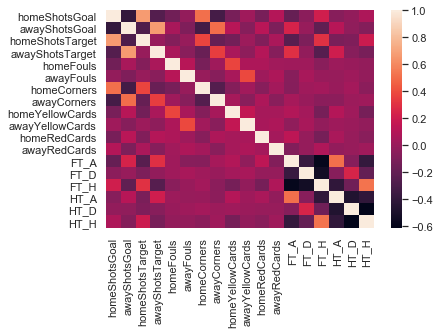

In [12]:
corr = data_two_hot.corr()
sns.set(font_scale=1.0)
sns.heatmap(corr)

plt.show()

# used code from jupyter notebook provided in labs


## 3.1.2 Effect of Red and Yellow Card effect

The data from the heatmap shows almost 0 correlation between cards given to teams and the final game result. In the following section, we deep dive into the correlation between wins and cards recieved.

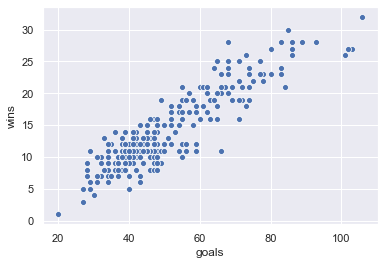

In [13]:
# Proof that red and yellow cards don't affect the result (in this case looking at number of wins):

# first eg of obvious case where attribute does affect number of wins:
scatter_data = df2[['wins', 'goals']]
scatter_data
scatter_plot = sns.scatterplot(x="goals", y="wins", data=scatter_data)
# positive correlation

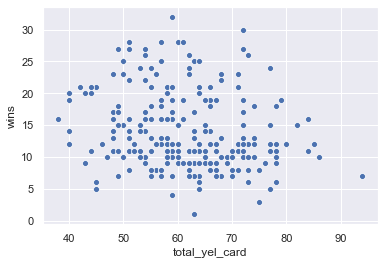

In [14]:
# yellow cards:
scatter_data1 = df2[['wins', 'total_yel_card']]
scatter_data1
scatter_plot1 = sns.scatterplot(x="total_yel_card", y="wins", data=scatter_data1)
# no correlation

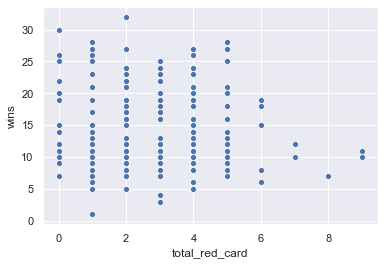

In [15]:
# red cards:
scatter_data2 = df2[['wins', 'total_red_card']]
scatter_data2
scatter_plot2 = sns.scatterplot(x="total_red_card", y="wins", data=scatter_data2)
# no correlation

## 3.1.3 Win Pattern Plots

Using our external dataset with team performance, we analyse the performance of the test match team pairings

In [16]:
# get relevant columns from dataframe
wins = df2[['team', 'wins', 'season']]
losses = df2[['team', 'losses', 'season']]

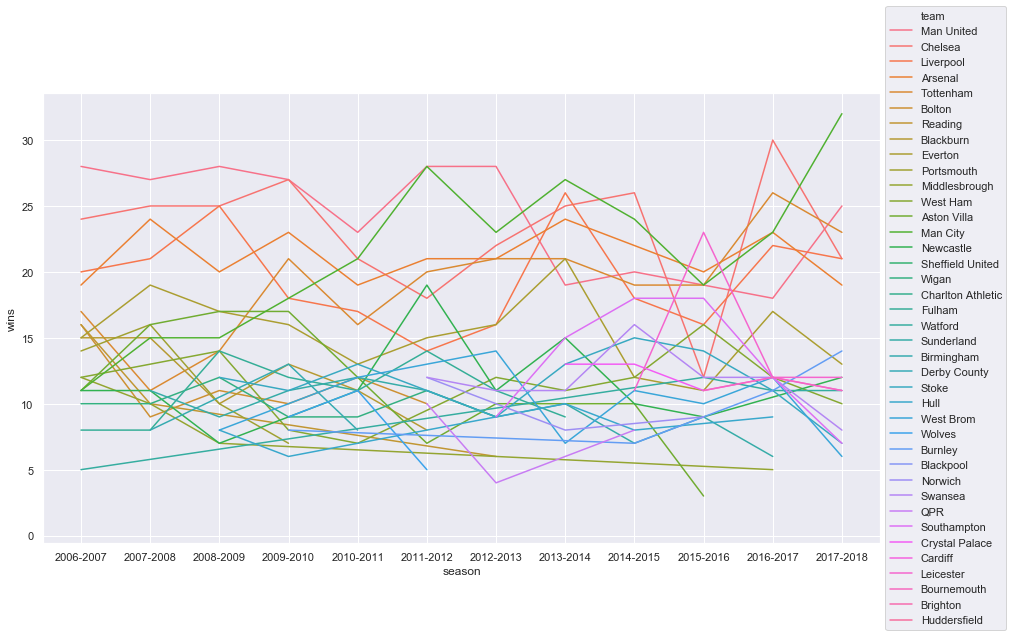

In [17]:
# plot pattern of wins for all teams over the seasons
sns.set(rc={'figure.figsize':(15,8.27)}) # https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot
g_wins = sns.lineplot(x="season", y="wins", hue="team", data=wins)
g_wins.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1) # https://stackoverflow.com/questions/53733755/how-to-move-legend-to-outside-of-a-seaborn-scatterplot/53737271

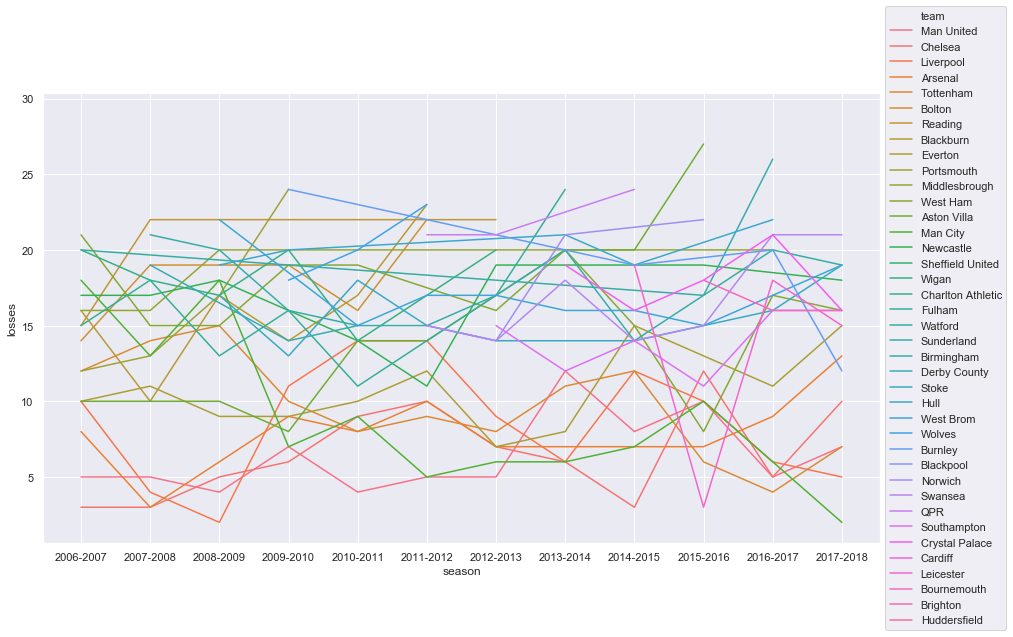

In [18]:
# plot pattern of losses for all teams over the seasons
g_losses = sns.lineplot(x="season", y="losses", hue="team", data=losses)
g_losses.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1)

Unknown team in Sheffield United vs. West Ham: Skipping


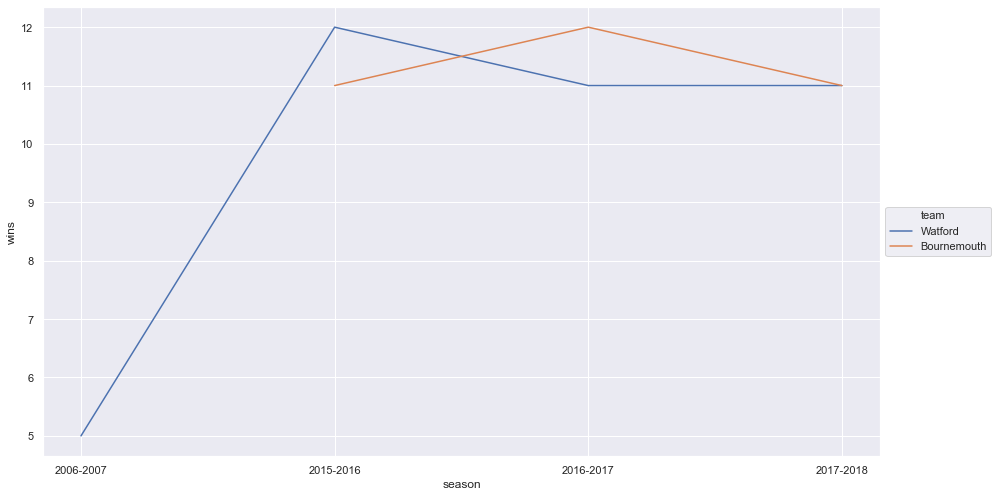

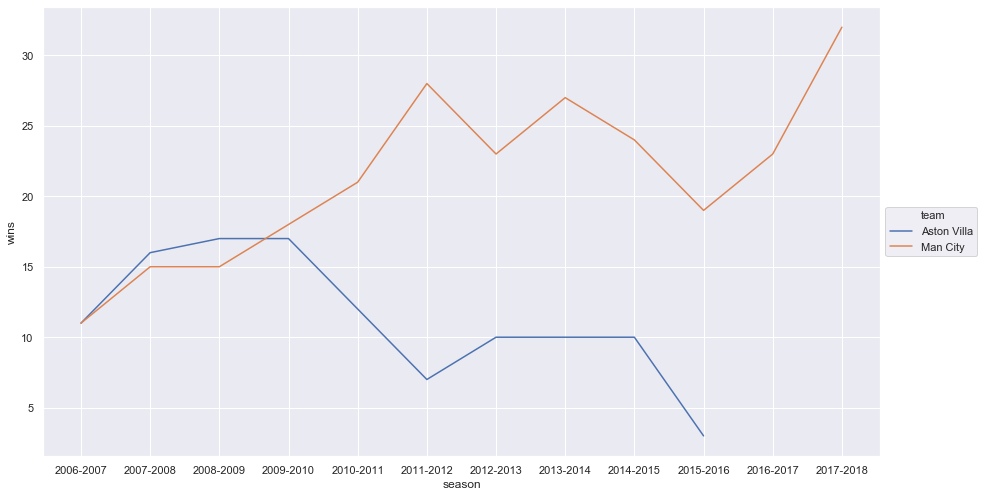

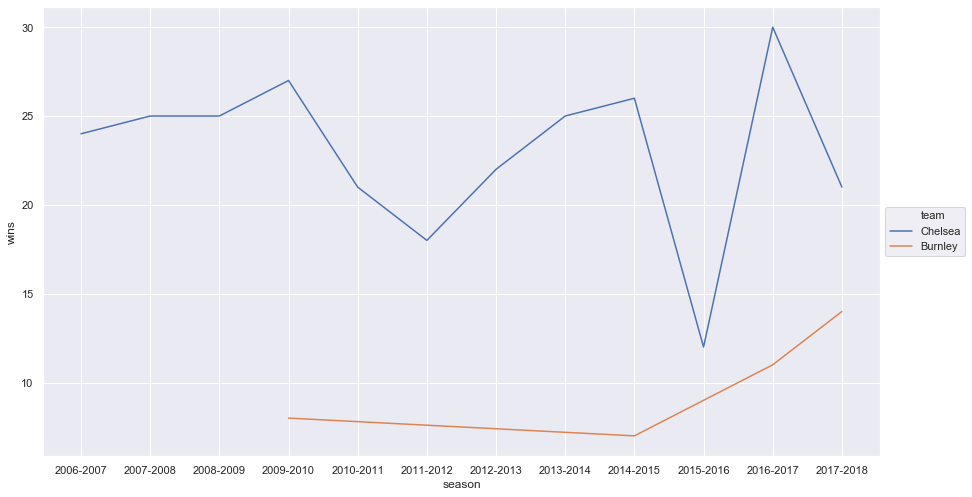

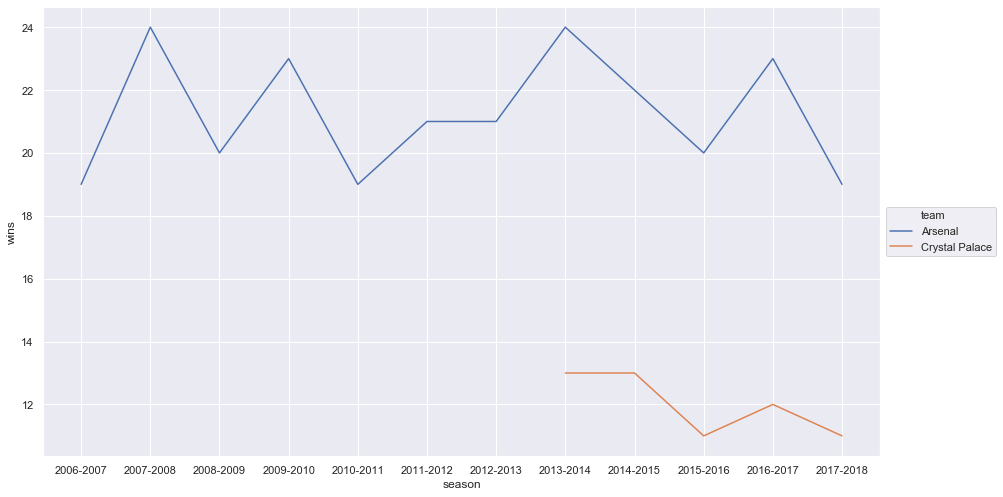

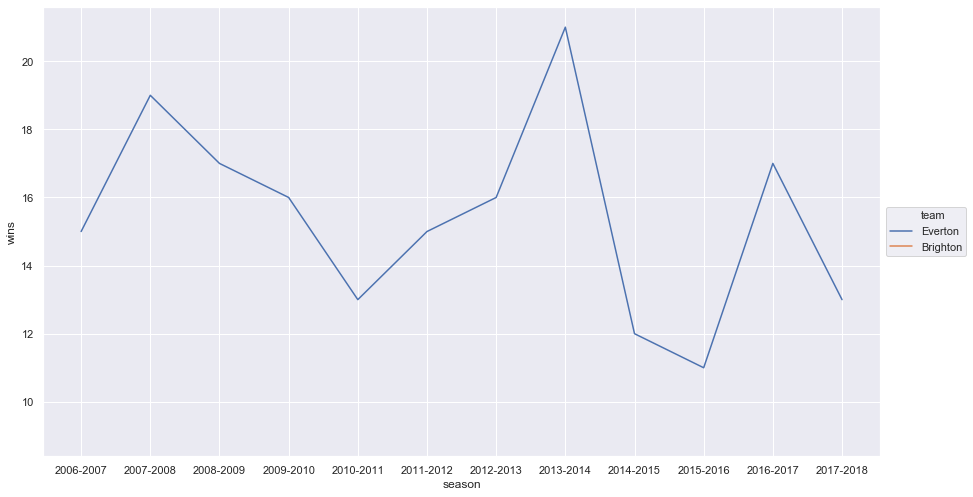

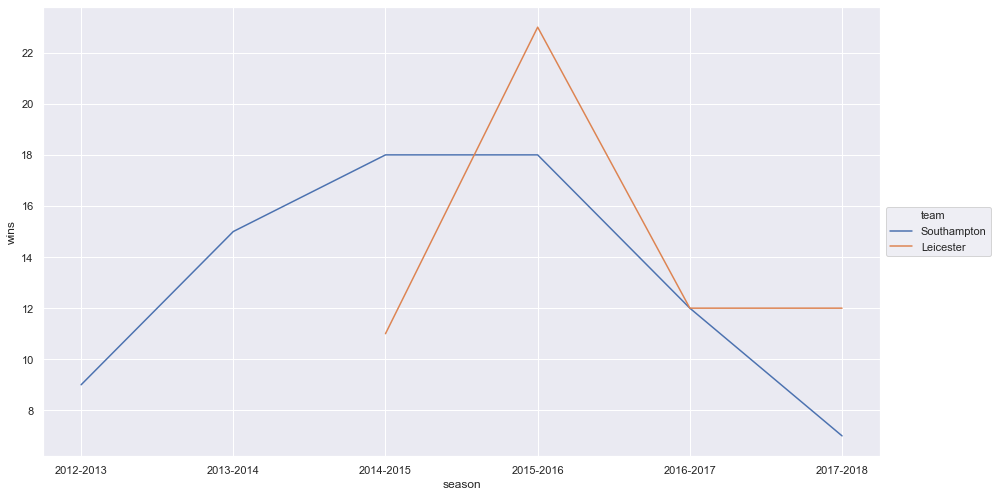

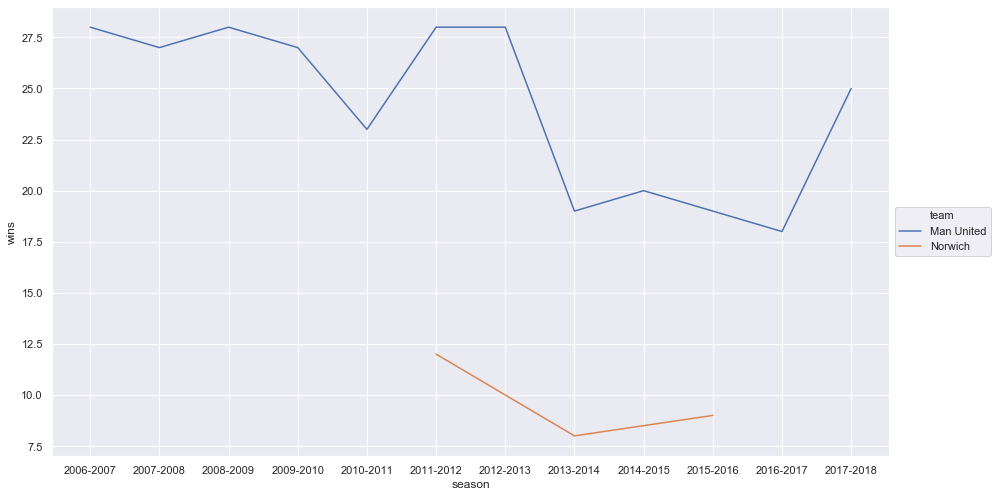

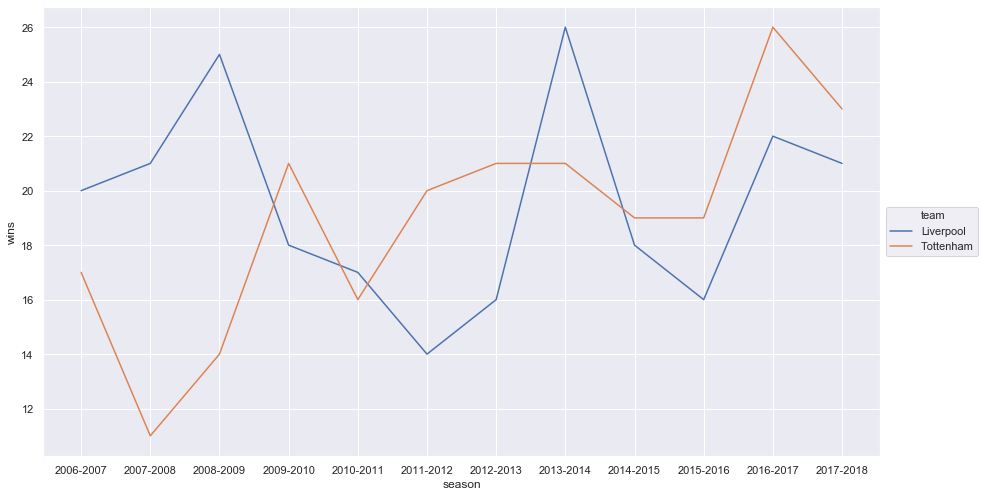

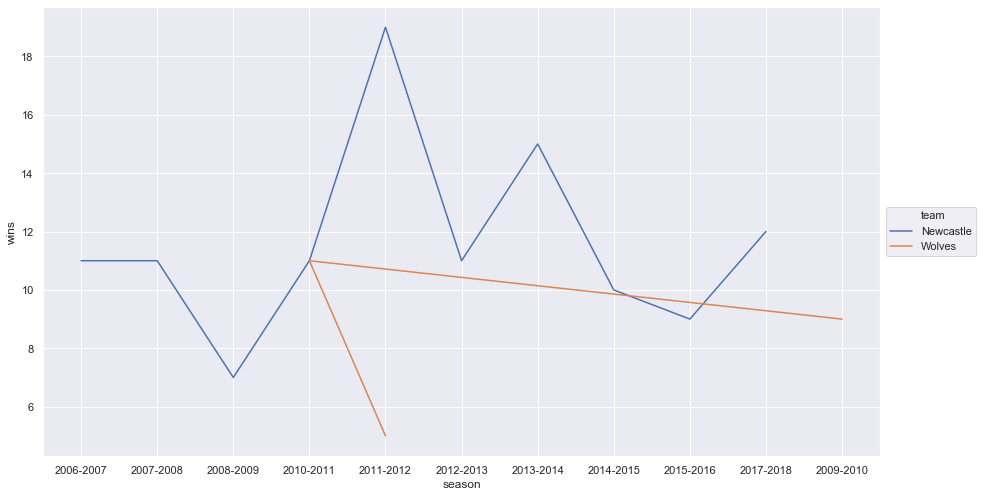

In [19]:
def show_win_trends(team_names):
    plt.figure()
    temp = wins[wins["team"].isin(team_names)]
    temp = sns.lineplot(x="season", y="wins", hue="team", data=temp)
    temp.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1)

for team_pair in test_teams:
    if np.any(team_names == team_pair[0]) and np.any(team_names == team_pair[1]):
        show_win_trends(team_pair)
    else:
        print("Unknown team in", team_pair[0], "vs.", team_pair[1] + ": Skipping")

# 3.2 Data Transformation

First, we create a data sheet for each team, specifying it's performance during each game played, whether at home or away.

In [20]:
# forms a data sheet specific to a team and reflects its performance for each game 
# the results evaluated are based on past games and are: 
# g_pct_avg	- averaged percentage of team's goals in games 
# htg_pct_avg	- averaged percentage of team's goals in games in half time
# s_pct_avg	- averaged percentage of shots made by the team
# st_pct_avg - averaged percentage of shots per target made by the team
# g_to_s_avg - averaged percentage of successful shots (goals/shots)
# g_to_st_avg	- averaged percentage of successful shots on target (goals/(shots on target))
# y_avg	- averaged number of yellow cards team received
# r_avg - - averaged number of red cards team received
def gen_team_table(df, team):  
    teamHome = df.loc[df['HomeTeam'] == team]
    teamHome = teamHome[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HTR', 'FTR', 'HS', 'AS', 'HST', 'AST', 'HY', 'HR']]
    teamHome = teamHome.rename(columns={"FTHG" : "FTG", "FTAG" : "VSG", "HS" : "S", "AS" : "VSS", "HST" : "ST", "AST" : "VSST", "HTHG" : "HTG", "HTAG" : "VSHG", "HY" : "Y", "HR" : "R"})
    # encode win = 1, lose = 0, draw = 2
    teamHome = teamHome.replace({'H' : 1, 'A' : 0, 'D': 2})
    teamAway = df.loc[df['AwayTeam'] == team]
    teamAway = teamAway[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HTR', 'FTR', 'HS', 'AS', 'HST', 'AST', 'AY', 'AR']]
    teamAway = teamAway.rename(columns={"FTHG" : "VSG", "FTAG" : "FTG", "HTHG" : "VSHG", "HS" : "VSS", "AS" : "S", "HST" : "VSST", "AST" : "ST", "HTAG" : "HTG", "AY" : "Y", "AR" : "R"})
    teamAway = teamAway.replace({'A' : 1, 'H' : 0, 'D' : 2})
    team = pd.concat([teamHome, teamAway], sort=False)
    team['Date'] = pd.to_datetime(team.Date, dayfirst=True)
    team = team.sort_values(by=['Date'])
    team['goals'] = team['FTG'] + team['VSG']
    team['htgoals'] = team['HTG'] + team['VSHG']
    team['shots'] = team['S'] + team['VSS']
    team['shotst'] = team['ST'] + team['VSST']
    team['goalspercent'] = team['FTG']*100/team['goals']
    team['htgoalspercent'] = team['HTG']*100/team['htgoals']
    team['shotspercent'] = team['S']*100/team['shots']
    team['shotstpercent'] = team['ST']*100/team['shotst']
    team['goalstos'] = team['FTG']*100/team['S']
    team['goalstost'] = team['FTG']*100/team['ST']
    team['g_pct_avg'] = team['goalspercent'].expanding().mean()
    team['htg_pct_avg'] = team['htgoalspercent'].expanding().mean()
    team['s_pct_avg'] = team['shotspercent'].expanding().mean()
    team['st_pct_avg'] = team['shotstpercent'].expanding().mean()
    team['g_to_s_avg'] = team['goalstos'].expanding().mean()
    team['g_to_st_avg'] = team['goalstost'].expanding().mean()
    team['y_avg'] = team['Y'].expanding().mean()
    team['r_avg'] = team['R'].expanding().mean()
    team = team.drop(['FTG', 'VSG', 'HTG', 'VSHG', 'S', 'VSS', 'ST', 'VSST', 'R', 'Y', 'goals', 'shots', 'shotst', 'htgoals', 'goalspercent', 'htgoalspercent', 'shotspercent', 'shotstpercent', 'goalstos', 'goalstost'], axis = 1)
    team = team.reset_index(drop = True)
    # nan or inf are set to 0
    team = team.replace(np.inf, 0)
    team = team.fillna(0)
    return team

# form teams' data sheets as dict
team_statistics = {}
for team_name in team_names:
    team_statistics[team_name] = gen_team_table(df, team_name)

In [21]:
# example of the obtained table
team_statistics["Wolves"]

,Date,HomeTeam,AwayTeam,HTR,FTR,g_pct_avg,htg_pct_avg,s_pct_avg,st_pct_avg,g_to_s_avg,g_to_st_avg,y_avg,r_avg
0,2009-08-15,Wolves,West Ham,0,0,0.000000,0.000000,54.285714,45.833333,0.000000,0.000000,0.000000,0.000000
1,2009-08-18,Wigan,Wolves,1,1,50.000000,50.000000,43.809524,41.666667,5.555556,16.666667,1.500000,0.000000
2,2009-08-22,Man City,Wolves,0,0,33.333333,33.333333,42.026862,32.905983,3.703704,11.111111,1.333333,0.000000
3,2009-08-29,Wolves,Hull,0,2,37.500000,25.000000,52.209802,44.917582,3.819444,9.803922,1.000000,0.000000
4,2009-09-12,Blackburn,Wolves,0,0,35.000000,20.000000,49.949660,42.600733,5.277778,11.843137,1.200000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,2019-04-20,Wolves,Brighton,2,2,39.739796,37.237237,43.743645,42.054930,10.925504,23.622064,1.729730,0.074324
148,2019-04-24,Wolves,Arsenal,1,1,39.989868,37.797619,43.785633,42.276038,11.035217,24.148808,1.731544,0.073826
149,2019-04-27,Watford,Wolves,1,1,40.177733,38.348083,43.842936,42.527531,11.082861,24.325871,1.733333,0.073333
150,2019-05-04,Wolves,Fulham,2,1,40.596071,38.348083,44.055896,42.742581,11.044320,24.273768,1.728477,0.072848


## 3.2.2 Team performance

Here, we compare performance of our test match teams.

Unknown team in Sheffield United vs. West Ham: Skipping


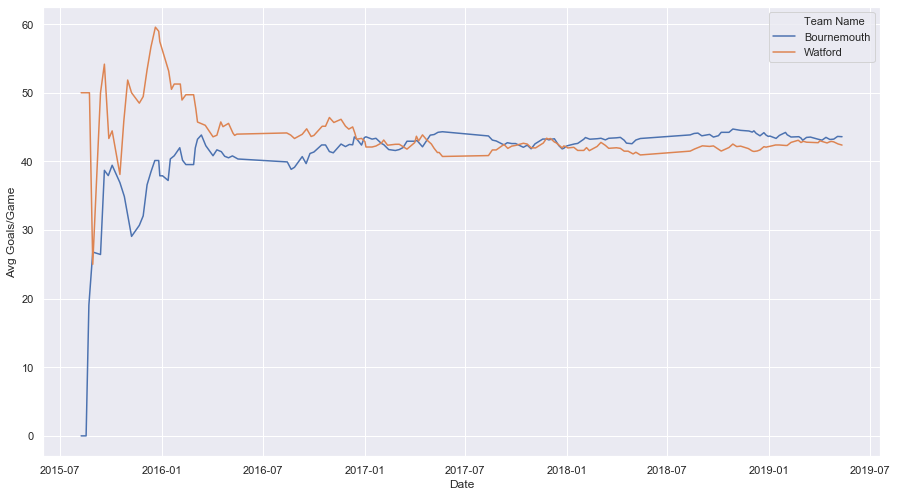

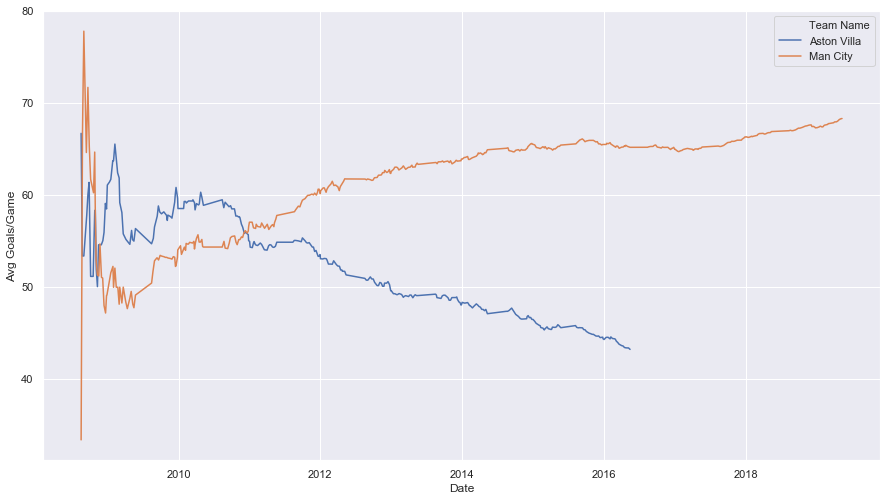

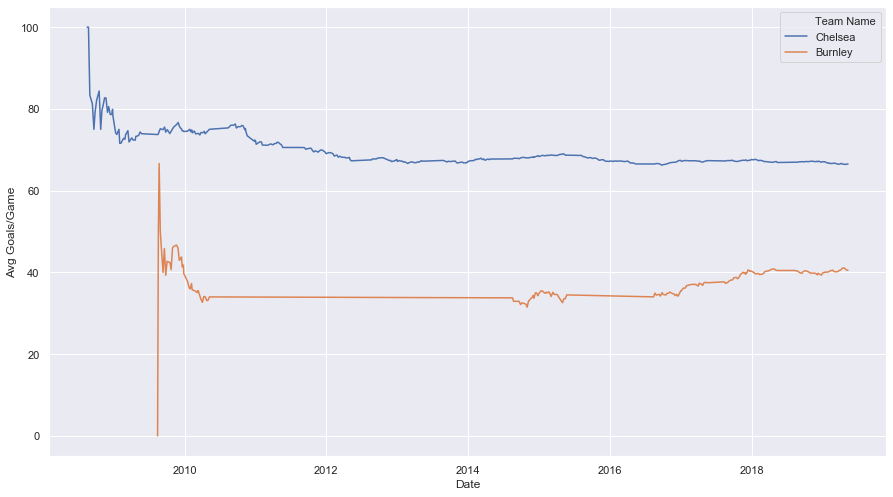

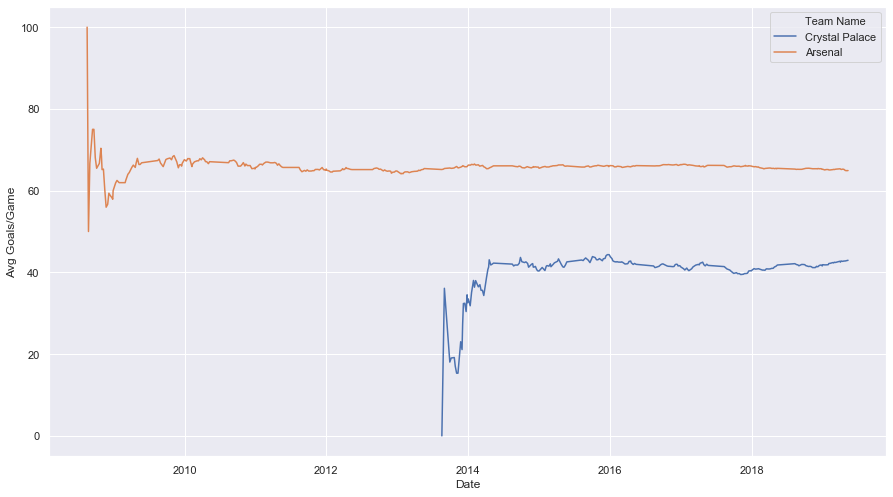

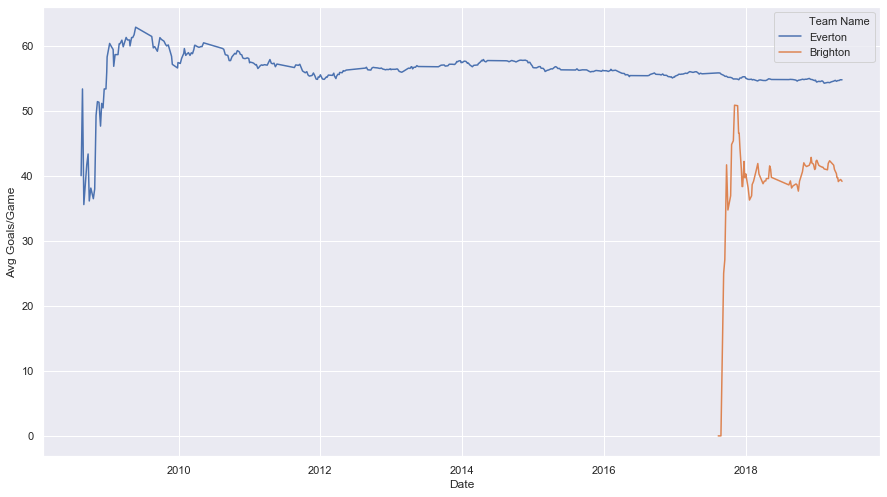

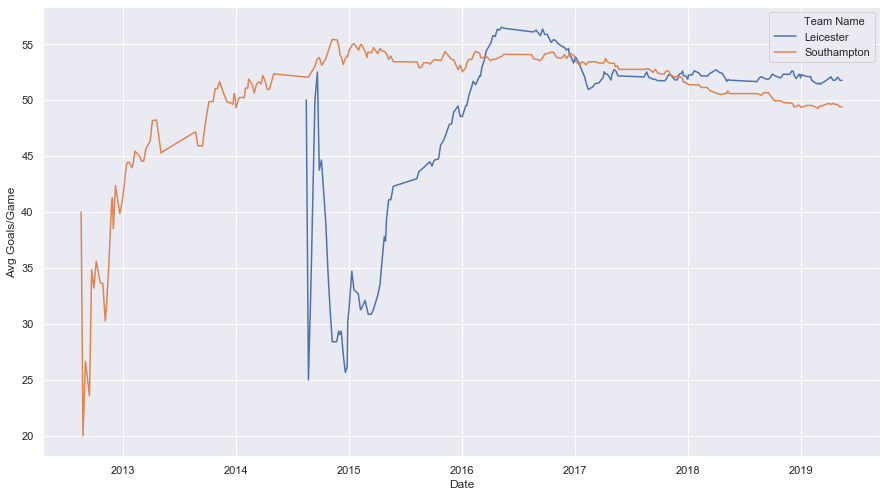

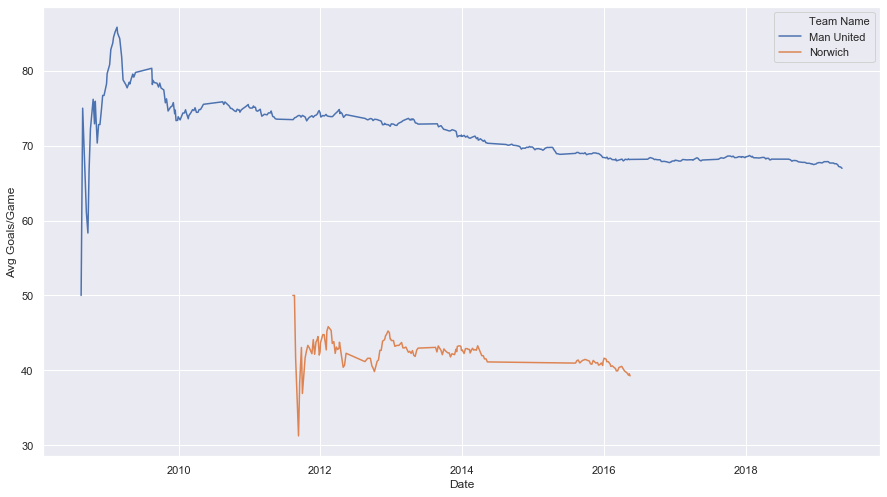

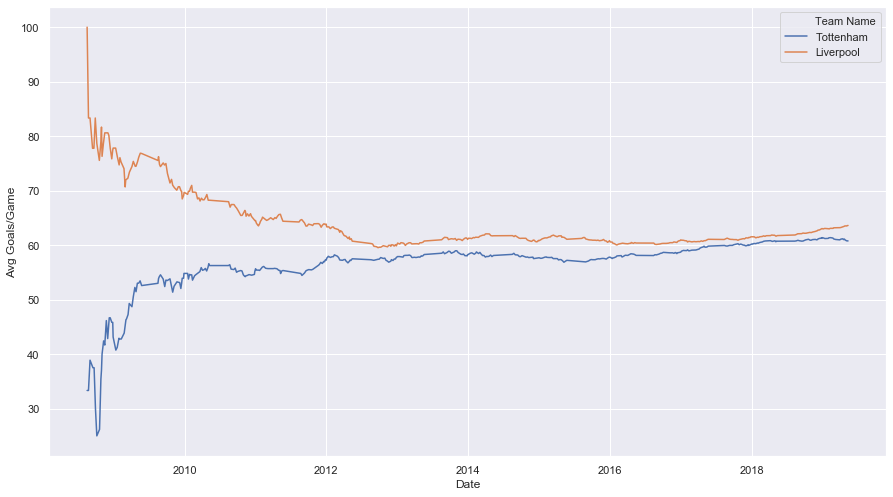

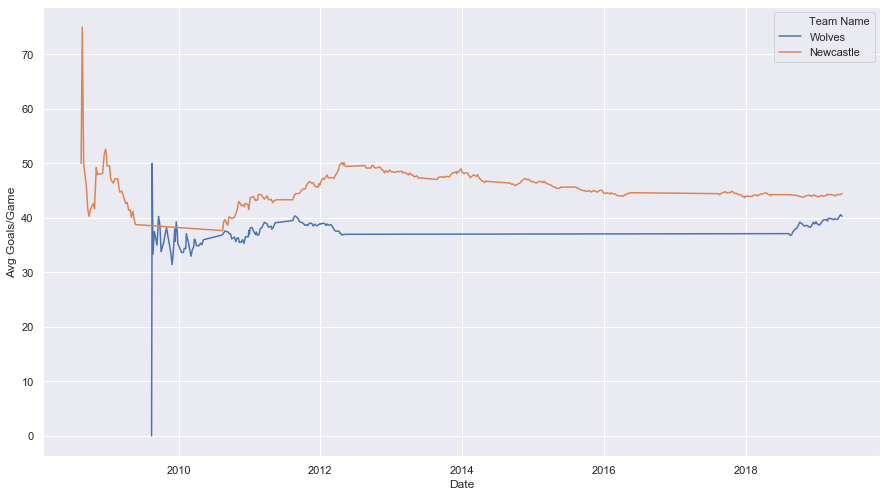

In [22]:
def show_performance_comparison(team_names):
    plt.figure()
    arr = []
    for team_name in team_names:
        # get the relevant team data sheet for the two teams in the first test case
        # drop columns that are not required and add a 'team' column
        test = team_statistics[team_name].copy()
        test = test[["Date", "g_pct_avg"]] # Isolate Avg Goals/Game
        test["Team Name"] = team_name
        test = test.rename(columns = {"g_pct_avg": "Avg Goals/Game"})
        arr.append(test)

    # want to plot graph depicting pattern of goals percentage average over all the dates for the two teams
    concatenated1 = pd.concat(arr)
    concatenated1
    plot1 = sns.lineplot(x="Date", y="Avg Goals/Game", hue="Team Name", data=concatenated1)

for team_pair in test_teams:
    if np.any(team_names == team_pair[0]) and np.any(team_names == team_pair[1]):
        show_performance_comparison(team_pair)
    else:
        print("Unknown team in", team_pair[0], "vs.", team_pair[1] + ": Skipping")


## 3.2.3 Merge games and team statistics

In [23]:
# make a list of games and results with standartised date
dfgames = df.copy()[['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'HTR']]
dfgames['Date'] = pd.to_datetime(dfgames["Date"], dayfirst=True)
dfgames 

,Date,HomeTeam,AwayTeam,FTR,HTR
0,2008-08-16,Arsenal,West Brom,H,H
1,2008-08-16,Bolton,Stoke,H,H
2,2008-08-16,Everton,Blackburn,A,D
3,2008-08-16,Hull,Fulham,H,D
4,2008-08-16,Middlesbrough,Tottenham,H,D
...,...,...,...,...,...
4175,2019-05-12,Liverpool,Wolves,H,H
4176,2019-05-12,Man United,Cardiff,A,A
4177,2019-05-12,Southampton,Huddersfield,D,H
4178,2019-05-12,Tottenham,Everton,D,H


In [24]:
teams = list(team_statistics.values())

In [25]:
# merge teams' data sheets to match the given data
# followed by cutting out NaN values
d1 = dfgames.copy()
d1 = functools.reduce(lambda  left,right: pd.merge(
    left,right,on=['Date', 'HomeTeam', 'AwayTeam'], how='outer'
    ), teams)
# https://stackoverflow.com/questions/49795825/skip-nan-and-shift-elements-in-a-pandas-dataframe-row
d10 = d1.apply(lambda x: pd.Series(x.dropna().values), axis=1).fillna('')
d10.columns = d1.columns[0:23]
d1 = d10
d1

,Date,HomeTeam,AwayTeam,HTR_x,FTR_x,g_pct_avg_x,htg_pct_avg_x,s_pct_avg_x,st_pct_avg_x,g_to_s_avg_x,g_to_st_avg_x,y_avg_x,r_avg_x,HTR_y,FTR_y,g_pct_avg_y,htg_pct_avg_y,s_pct_avg_y,st_pct_avg_y,g_to_s_avg_y,g_to_st_avg_y,y_avg_y,r_avg_y
0,2008-08-16,Arsenal,West Brom,1.0,1.0,100.000000,100.000000,82.758621,77.777778,4.166667,7.142857,0.000000,0.000000,0.0,0.0,0.000000,0.000000,17.241379,22.222222,0.000000,0.000000,0.000000,0.000000
1,2008-08-23,Fulham,Arsenal,0.0,0.0,50.000000,50.000000,78.879310,76.388889,2.083333,3.571429,0.000000,0.000000,1.0,1.0,66.666667,75.000000,38.586957,37.500000,14.166667,33.333333,1.000000,0.000000
2,2008-08-30,Arsenal,Newcastle,1.0,1.0,66.666667,66.666667,80.363985,80.092593,6.388889,9.523810,0.666667,0.000000,0.0,0.0,50.000000,25.000000,35.743093,34.722222,6.363636,12.500000,1.000000,0.000000
3,2008-09-13,Blackburn,Arsenal,1.0,1.0,75.000000,75.000000,76.013729,79.300214,10.674020,17.142857,0.750000,0.000000,0.0,0.0,32.500000,33.333333,53.092211,50.307158,9.166667,15.389610,2.000000,0.000000
4,2008-09-20,Bolton,Arsenal,1.0,1.0,75.000000,73.333333,73.310983,74.028406,11.539216,20.380952,1.000000,0.000000,0.0,0.0,33.333333,44.444444,47.415243,50.328431,8.452381,12.857143,1.600000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,2010-01-16,Wolves,Wigan,2.0,1.0,43.621795,43.589744,52.866689,52.139395,8.880463,17.235222,1.568966,0.086207,2.0,0.0,33.662132,29.411765,43.668652,41.476201,8.312891,13.451623,2.000000,0.142857
4176,2010-10-02,Wigan,Wolves,2.0,1.0,41.463964,40.606061,54.059987,53.005532,7.714336,14.886176,1.662651,0.084337,2.0,0.0,36.144019,42.647059,41.492742,40.814271,10.078983,19.061769,1.888889,0.133333
4177,2010-12-26,Wolves,Wigan,1.0,1.0,41.587302,40.053763,53.413383,52.945666,7.815072,14.937912,1.617021,0.095745,0.0,0.0,36.510989,38.636364,42.988872,42.482528,10.062499,18.648405,1.767857,0.107143
4178,2011-11-06,Wolves,Wigan,2.0,0.0,40.063211,38.293651,51.680022,51.149488,8.290450,15.298638,1.712000,0.096000,2.0,1.0,39.041812,40.096618,43.133442,42.114879,10.760890,20.960199,1.724138,0.068966


In [26]:
# sort rows to match initial values
d1 = d1.sort_values(by=['Date', 'HomeTeam', 'AwayTeam'])
d1

,Date,HomeTeam,AwayTeam,HTR_x,FTR_x,g_pct_avg_x,htg_pct_avg_x,s_pct_avg_x,st_pct_avg_x,g_to_s_avg_x,g_to_st_avg_x,y_avg_x,r_avg_x,HTR_y,FTR_y,g_pct_avg_y,htg_pct_avg_y,s_pct_avg_y,st_pct_avg_y,g_to_s_avg_y,g_to_st_avg_y,y_avg_y,r_avg_y
0,2008-08-16,Arsenal,West Brom,1.0,1.0,100.000000,100.000000,82.758621,77.777778,4.166667,7.142857,0.000000,0.000000,0.0,0.0,0.000000,0.000000,17.241379,22.222222,0.000000,0.000000,0.000000,0.000000
936,2008-08-16,Bolton,Stoke,1.0,1.0,75.000000,100.000000,63.636364,80.000000,21.428571,37.500000,1.000000,0.000000,0.0,0.0,25.000000,0.000000,36.363636,20.000000,12.500000,50.000000,2.000000,0.000000
774,2008-08-16,Everton,Blackburn,2.0,1.0,60.000000,50.000000,60.000000,68.750000,20.000000,27.272727,2.000000,0.000000,2.0,0.0,40.000000,50.000000,40.000000,31.250000,20.000000,40.000000,2.000000,0.000000
2296,2008-08-16,Hull,Fulham,2.0,0.0,33.333333,50.000000,52.173913,50.000000,8.333333,16.666667,0.000000,0.000000,2.0,1.0,66.666667,50.000000,47.826087,50.000000,18.181818,33.333333,3.000000,0.000000
3396,2008-08-16,Middlesbrough,Tottenham,2.0,1.0,66.666667,0.000000,63.636364,66.666667,14.285714,20.000000,1.000000,0.000000,2.0,0.0,33.333333,0.000000,36.363636,33.333333,12.500000,20.000000,2.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,2019-05-12,Liverpool,Wolves,1.0,1.0,63.616201,64.555556,61.963599,63.439077,12.472913,29.216259,1.423445,0.057416,0.0,0.0,40.314153,38.011696,43.996318,42.649350,10.971660,24.109756,1.730263,0.072368
1491,2019-05-12,Man United,Cardiff,1.0,1.0,32.573529,24.826389,40.010119,35.994707,8.040150,24.427910,1.500000,0.026316,0.0,0.0,66.973314,68.965382,56.529159,58.602667,13.760722,30.244172,1.648325,0.071770
2513,2019-05-12,Southampton,Huddersfield,0.0,2.0,28.847481,29.833333,43.967520,39.843391,6.681185,20.771853,1.526316,0.092105,1.0,2.0,49.402778,49.664804,53.430232,54.257890,9.801246,28.434825,1.537594,0.067669
2295,2019-05-12,Tottenham,Everton,0.0,2.0,54.735622,53.534994,51.562353,53.372285,11.911652,26.750786,1.497608,0.069378,1.0,2.0,60.772947,59.129693,57.767649,59.271507,11.718863,26.784780,1.545455,0.062201


In [27]:
d2 = d1.iloc[:,0:23].copy()
d2 = d2.drop(['HTR_x', 'FTR_x', 'HTR_y', 'FTR_y'], axis = 1)
d2 = d2.reset_index(drop=True)
d2

,Date,HomeTeam,AwayTeam,g_pct_avg_x,htg_pct_avg_x,s_pct_avg_x,st_pct_avg_x,g_to_s_avg_x,g_to_st_avg_x,y_avg_x,r_avg_x,g_pct_avg_y,htg_pct_avg_y,s_pct_avg_y,st_pct_avg_y,g_to_s_avg_y,g_to_st_avg_y,y_avg_y,r_avg_y
0,2008-08-16,Arsenal,West Brom,100.000000,100.000000,82.758621,77.777778,4.166667,7.142857,0.000000,0.000000,0.000000,0.000000,17.241379,22.222222,0.000000,0.000000,0.000000,0.000000
1,2008-08-16,Bolton,Stoke,75.000000,100.000000,63.636364,80.000000,21.428571,37.500000,1.000000,0.000000,25.000000,0.000000,36.363636,20.000000,12.500000,50.000000,2.000000,0.000000
2,2008-08-16,Everton,Blackburn,60.000000,50.000000,60.000000,68.750000,20.000000,27.272727,2.000000,0.000000,40.000000,50.000000,40.000000,31.250000,20.000000,40.000000,2.000000,0.000000
3,2008-08-16,Hull,Fulham,33.333333,50.000000,52.173913,50.000000,8.333333,16.666667,0.000000,0.000000,66.666667,50.000000,47.826087,50.000000,18.181818,33.333333,3.000000,0.000000
4,2008-08-16,Middlesbrough,Tottenham,66.666667,0.000000,63.636364,66.666667,14.285714,20.000000,1.000000,0.000000,33.333333,0.000000,36.363636,33.333333,12.500000,20.000000,2.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,2019-05-12,Liverpool,Wolves,63.616201,64.555556,61.963599,63.439077,12.472913,29.216259,1.423445,0.057416,40.314153,38.011696,43.996318,42.649350,10.971660,24.109756,1.730263,0.072368
4176,2019-05-12,Man United,Cardiff,32.573529,24.826389,40.010119,35.994707,8.040150,24.427910,1.500000,0.026316,66.973314,68.965382,56.529159,58.602667,13.760722,30.244172,1.648325,0.071770
4177,2019-05-12,Southampton,Huddersfield,28.847481,29.833333,43.967520,39.843391,6.681185,20.771853,1.526316,0.092105,49.402778,49.664804,53.430232,54.257890,9.801246,28.434825,1.537594,0.067669
4178,2019-05-12,Tottenham,Everton,54.735622,53.534994,51.562353,53.372285,11.911652,26.750786,1.497608,0.069378,60.772947,59.129693,57.767649,59.271507,11.718863,26.784780,1.545455,0.062201


In [28]:
# now we need to order data
# we know tables were merged alphabetically, so data in the rows for team _x and team _y is reversed
# so we rename all the columns in the rows of interest and put the columns in the initial order
toorder = d2[np.greater(d2['HomeTeam'], d2['AwayTeam'])]
toorder = toorder.rename(columns={
    'g_pct_avg_x' : 'g_pct_avg_y', 
    'htg_pct_avg_x' : 'htg_pct_avg_y',
    's_pct_avg_x' : 's_pct_avg_y',
    'st_pct_avg_x' : 'st_pct_avg_y',
    'g_to_s_avg_x' : 'g_to_s_avg_y',
    'g_to_st_avg_x' : 'g_to_st_avg_y',
    'y_avg_x' : 'y_avg_y',
    'r_avg_x' : 'r_avg_y',
    'g_pct_avg_y' : 'g_pct_avg_x',
    'htg_pct_avg_y' : 'htg_pct_avg_x',
    's_pct_avg_y' : 's_pct_avg_x',
    'st_pct_avg_y' : 'st_pct_avg_x',
    'g_to_s_avg_y' : 'g_to_s_avg_x',
    'g_to_st_avg_y' : 'g_to_st_avg_x',
    'y_avg_y' : 'y_avg_x',
    'r_avg_y' : 'r_avg_x'
    })
toorder = toorder[[
    'Date', 
    'HomeTeam',
    'AwayTeam',
    'g_pct_avg_x',
    'htg_pct_avg_x',
    's_pct_avg_x',
    'st_pct_avg_x',
    'g_to_s_avg_x',
    'g_to_st_avg_x',
    'y_avg_x',
    'r_avg_x',
    'g_pct_avg_y',
    'htg_pct_avg_y',
    's_pct_avg_y',
    'st_pct_avg_y',
    'g_to_s_avg_y',
    'g_to_st_avg_y',
    'y_avg_y',
    'r_avg_y'
    ]]

In [29]:
d3 = d2.loc[toorder.index] = toorder
d3

,Date,HomeTeam,AwayTeam,g_pct_avg_x,htg_pct_avg_x,s_pct_avg_x,st_pct_avg_x,g_to_s_avg_x,g_to_st_avg_x,y_avg_x,r_avg_x,g_pct_avg_y,htg_pct_avg_y,s_pct_avg_y,st_pct_avg_y,g_to_s_avg_y,g_to_st_avg_y,y_avg_y,r_avg_y
2,2008-08-16,Everton,Blackburn,40.000000,50.000000,40.000000,31.250000,20.000000,40.000000,2.000000,0.000000,60.000000,50.000000,60.000000,68.750000,20.000000,27.272727,2.000000,0.000000
3,2008-08-16,Hull,Fulham,66.666667,50.000000,47.826087,50.000000,18.181818,33.333333,3.000000,0.000000,33.333333,50.000000,52.173913,50.000000,8.333333,16.666667,0.000000,0.000000
5,2008-08-16,Sunderland,Liverpool,0.000000,0.000000,30.000000,27.272727,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,70.000000,72.727273,7.142857,12.500000,2.000000,0.000000
11,2008-08-23,Fulham,Arsenal,66.666667,75.000000,38.586957,37.500000,14.166667,33.333333,1.000000,0.000000,50.000000,50.000000,78.879310,76.388889,2.083333,3.571429,0.000000,0.000000
13,2008-08-23,Newcastle,Bolton,75.000000,50.000000,45.281307,45.833333,9.545455,18.750000,0.500000,0.000000,37.500000,100.000000,55.502392,56.666667,10.714286,18.750000,1.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4172,2019-05-12,Crystal Palace,Bournemouth,42.959373,40.804598,46.865651,46.031302,10.068642,29.791758,1.692982,0.039474,43.593750,44.237288,46.762129,47.321482,11.153137,31.900740,1.434211,0.039474
4174,2019-05-12,Leicester,Chelsea,51.751637,48.908873,48.095321,49.078833,12.105023,35.620277,1.457895,0.094737,66.501084,68.709150,60.671491,61.636905,12.550067,29.876424,1.543062,0.078947
4176,2019-05-12,Man United,Cardiff,66.973314,68.965382,56.529159,58.602667,13.760722,30.244172,1.648325,0.071770,32.573529,24.826389,40.010119,35.994707,8.040150,24.427910,1.500000,0.026316
4177,2019-05-12,Southampton,Huddersfield,49.402778,49.664804,53.430232,54.257890,9.801246,28.434825,1.537594,0.067669,28.847481,29.833333,43.967520,39.843391,6.681185,20.771853,1.526316,0.092105


In [30]:
# since we'll be using results from the initial table, we need to make sure all rows are in order
# we find out rows 2926 and 2927 must be swapped
d2.loc[toorder.index] = toorder
result = d2
temp = result.iloc[2926].copy()
result.iloc[2926] = result.iloc[2927]
result.iloc[2927] = temp
result['HTR'] = df['HTR']
result['FTR'] = df['FTR']

In [31]:
# this ensures the correctness of ordering
truth = result['HomeTeam'].equals(df['HomeTeam'])
truth

True

In [32]:
# encode home = 0, away = 1, draw = 2, team names = {0,1,...,35}
result = result.replace({'H' : 0, 'A' : 1, 'D': 2})
result = result.replace({'Arsenal' : 0, 'Aston Villa' : 1, 'Birmingham' : 2, 'Blackburn' : 3, 'Blackpool' : 4,
       'Bolton' : 5, 'Bournemouth' : 6, 'Brighton' : 7, 'Burnley' : 8, 'Cardiff' : 9,
       'Chelsea' : 10, 'Crystal Palace' : 11, 'Everton' : 12, 'Fulham' : 13, 'Huddersfield' : 14,
       'Hull' : 15, 'Leicester' : 16, 'Liverpool' : 17, 'Man City' : 18, 'Man United' : 19,
       'Middlesbrough' : 20, 'Newcastle' : 21, 'Norwich' : 22, 'Portsmouth' : 23, 'QPR' : 24,
       'Reading' : 25, 'Southampton' : 26, 'Stoke' : 27, 'Sunderland' : 28, 'Swansea' : 29,
       'Tottenham' : 30, 'Watford' : 31, 'West Brom' : 32, 'West Ham' : 33, 'Wigan' : 34, 'Wolves' : 35, 'Sheffield United' : 36})

In [33]:
result

,Date,HomeTeam,AwayTeam,g_pct_avg_x,htg_pct_avg_x,s_pct_avg_x,st_pct_avg_x,g_to_s_avg_x,g_to_st_avg_x,y_avg_x,r_avg_x,g_pct_avg_y,htg_pct_avg_y,s_pct_avg_y,st_pct_avg_y,g_to_s_avg_y,g_to_st_avg_y,y_avg_y,r_avg_y,HTR,FTR
0,2008-08-16,0,32,100.000000,100.000000,82.758621,77.777778,4.166667,7.142857,0.000000,0.000000,0.000000,0.000000,17.241379,22.222222,0.000000,0.000000,0.000000,0.000000,0,0
1,2008-08-16,5,27,75.000000,100.000000,63.636364,80.000000,21.428571,37.500000,1.000000,0.000000,25.000000,0.000000,36.363636,20.000000,12.500000,50.000000,2.000000,0.000000,0,0
2,2008-08-16,12,3,40.000000,50.000000,40.000000,31.250000,20.000000,40.000000,2.000000,0.000000,60.000000,50.000000,60.000000,68.750000,20.000000,27.272727,2.000000,0.000000,2,1
3,2008-08-16,15,13,66.666667,50.000000,47.826087,50.000000,18.181818,33.333333,3.000000,0.000000,33.333333,50.000000,52.173913,50.000000,8.333333,16.666667,0.000000,0.000000,2,0
4,2008-08-16,20,30,66.666667,0.000000,63.636364,66.666667,14.285714,20.000000,1.000000,0.000000,33.333333,0.000000,36.363636,33.333333,12.500000,20.000000,2.000000,0.000000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,2019-05-12,17,35,63.616201,64.555556,61.963599,63.439077,12.472913,29.216259,1.423445,0.057416,40.314153,38.011696,43.996318,42.649350,10.971660,24.109756,1.730263,0.072368,0,0
4176,2019-05-12,19,9,66.973314,68.965382,56.529159,58.602667,13.760722,30.244172,1.648325,0.071770,32.573529,24.826389,40.010119,35.994707,8.040150,24.427910,1.500000,0.026316,1,1
4177,2019-05-12,26,14,49.402778,49.664804,53.430232,54.257890,9.801246,28.434825,1.537594,0.067669,28.847481,29.833333,43.967520,39.843391,6.681185,20.771853,1.526316,0.092105,0,2
4178,2019-05-12,30,12,60.772947,59.129693,57.767649,59.271507,11.718863,26.784780,1.545455,0.062201,54.735622,53.534994,51.562353,53.372285,11.911652,26.750786,1.497608,0.069378,0,2


## 3.2.4 ELO Ratings
In this section, we produce ELO ratings for each team so they can more easily be compared

Warning: Slow Computation


In [34]:
def gen_elo_ratings(df):
    df = df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]]
    df.loc[:, "GoalDiff"] = (df.loc[:, "FTHG"] - df.loc[:, "FTAG"]).abs()
    
    def get_G_coefficient(diff):
        if diff == 1 or diff == 0:
            return 1
        elif diff == 2:
            return 3/2
        else:
            return (11 + diff) / 8
        
    df.loc[:, 'G_coeff'] = df.copy()["GoalDiff"].apply(get_G_coefficient)
    
    def calculateResult(result, isHome):
        if result == "D":
            return 0.5

        if isHome == True:
            if result == "H":
                return 1
            elif result == "A":
                return 0
        elif isHome == False:
            if result == "H":
                return 0
            elif result == "A":
                return 1
    
    df.loc[:, 'FTR_Home'] = df.FTR.apply(calculateResult, isHome=True)
    df.loc[:, 'FTR_Away'] = df.FTR.apply(calculateResult, isHome=False)
    
    df.loc[:, "OldEloH"] = 1500
    df.loc[:, "OldEloA"] = 1500
    df.loc[:, "NewEloH"] = 1500
    df.loc[:, "NewEloA"] = 1500

    team_ratings = {}
    df.loc[:, 'ExpRes_H'] = 0
    df.loc[:, 'ExpRes_A'] = 0

    def calculateExpectedResult(index):
        ratingsDiff = df.loc[index,'OldEloH'] - df.loc[index,'OldEloA']
        return float(1/(10**(-ratingsDiff/400) + 1))

    def calculate_ELO(index, isHome):
        if isHome:
            return df.loc[index,'OldEloH'] + 30*(df.loc[index,"G_coeff"])*(df.loc[index,'FTR_Home'] - df.loc[index,'ExpRes_H'])
        else: 
            return df.loc[index,'OldEloA'] + 30*(df.loc[index,"G_coeff"])*(df.loc[index,'FTR_Away'] - df.loc[index,'ExpRes_A'])

    def calculate(index):
        if df.loc[index,'HomeTeam'] not in team_ratings:
            team_ratings[df.loc[index,'HomeTeam']] = df.loc[index,'OldEloH']
        else:
            df.loc[index,'OldEloH'] = team_ratings[df.loc[index,'HomeTeam']]

        if df.loc[index,'AwayTeam'] not in team_ratings:
            team_ratings[df.loc[index,'AwayTeam']] = df.loc[index,'OldEloA']
        else:
            df.loc[index,'OldEloA'] = team_ratings[df.loc[index,'AwayTeam']]

        df.loc[index,'ExpRes_H'] = calculateExpectedResult(index)
        df.loc[index,'ExpRes_A'] = 1 - df.loc[index,'ExpRes_H']

        df.loc[index,'NewEloH'] = calculate_ELO(index, True)
        df.loc[index,'NewEloA'] = calculate_ELO(index, False)

        team_ratings[df.loc[index,'HomeTeam']] = df.loc[index,'NewEloH']
        team_ratings[df.loc[index,'AwayTeam']] = df.loc[index,'NewEloA']

    for i in range(0,len(df.index)):
        calculate(i)
    
    return df

slow = False
if slow:
    elo = pd.read_csv()
else:
    elo = gen_elo_ratings(df)
# If the above is too slow to compute , set slow to True

/Users/ap/.pyenv/versions/pyds3.7/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ap/.pyenv/versions/pyds3.7/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [35]:
# Apply ELO ratings to final df
result['elo_x'] = elo['NewEloH']
result['elo_y'] = elo['NewEloA']
result

,Date,HomeTeam,AwayTeam,g_pct_avg_x,htg_pct_avg_x,s_pct_avg_x,st_pct_avg_x,g_to_s_avg_x,g_to_st_avg_x,y_avg_x,r_avg_x,g_pct_avg_y,htg_pct_avg_y,s_pct_avg_y,st_pct_avg_y,g_to_s_avg_y,g_to_st_avg_y,y_avg_y,r_avg_y,HTR,FTR,elo_x,elo_y
0,2008-08-16,0,32,100.000000,100.000000,82.758621,77.777778,4.166667,7.142857,0.000000,0.000000,0.000000,0.000000,17.241379,22.222222,0.000000,0.000000,0.000000,0.000000,0,0,1515.000000,1485.000000
1,2008-08-16,5,27,75.000000,100.000000,63.636364,80.000000,21.428571,37.500000,1.000000,0.000000,25.000000,0.000000,36.363636,20.000000,12.500000,50.000000,2.000000,0.000000,0,0,1522.500000,1477.500000
2,2008-08-16,12,3,40.000000,50.000000,40.000000,31.250000,20.000000,40.000000,2.000000,0.000000,60.000000,50.000000,60.000000,68.750000,20.000000,27.272727,2.000000,0.000000,2,1,1485.000000,1515.000000
3,2008-08-16,15,13,66.666667,50.000000,47.826087,50.000000,18.181818,33.333333,3.000000,0.000000,33.333333,50.000000,52.173913,50.000000,8.333333,16.666667,0.000000,0.000000,2,0,1515.000000,1485.000000
4,2008-08-16,20,30,66.666667,0.000000,63.636364,66.666667,14.285714,20.000000,1.000000,0.000000,33.333333,0.000000,36.363636,33.333333,12.500000,20.000000,2.000000,0.000000,2,0,1515.000000,1485.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,2019-05-12,17,35,63.616201,64.555556,61.963599,63.439077,12.472913,29.216259,1.423445,0.057416,40.314153,38.011696,43.996318,42.649350,10.971660,24.109756,1.730263,0.072368,0,0,1910.735960,1559.981204
4176,2019-05-12,19,9,66.973314,68.965382,56.529159,58.602667,13.760722,30.244172,1.648325,0.071770,32.573529,24.826389,40.010119,35.994707,8.040150,24.427910,1.500000,0.026316,1,1,1642.822454,1415.926392
4177,2019-05-12,26,14,49.402778,49.664804,53.430232,54.257890,9.801246,28.434825,1.537594,0.067669,28.847481,29.833333,43.967520,39.843391,6.681185,20.771853,1.526316,0.092105,0,2,1483.945014,1301.979178
4178,2019-05-12,30,12,60.772947,59.129693,57.767649,59.271507,11.718863,26.784780,1.545455,0.062201,54.735622,53.534994,51.562353,53.372285,11.911652,26.750786,1.497608,0.069378,0,2,1681.480450,1627.937951


# 4 Methodology Overview

In 3.1.2, We showed that red/yellow cards have little effect on the outcome statistically. We use this assumption and remove cards from the dataset.

### 4.2 Logistic regression

Excludes cards

In [36]:
# try data without yellow and red cards
y1 = result['FTR']
X1 = result
# some values are not suitable for predictions, so we drop them
X1 = X1.drop(['FTR', 'Date', 'y_avg_x',	'r_avg_x', 'y_avg_y',	'r_avg_y', 'HTR'], axis=1)
X1[:] = X1[:].astype(float)

In [37]:
# 1st model, LR on all attributes without cards
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,test_size=0.25,random_state=0, shuffle = False)
# Create one-vs-rest logistic regression object and train the model
clf1 = LogisticRegression(random_state=0, multi_class='ovr', solver='newton-cg')
model1 = clf1.fit(X_train1, y_train1)
y_pred1 = model1.predict(X_test1)
model1.predict_proba(X_test1)
lr_withoutcards_accuracy = metrics.accuracy_score(y_test1, y_pred1)
print("Accuracy: {0:.2%}".format(metrics.accuracy_score(y_test1, y_pred1)))

Accuracy: 62.68%


In [38]:
# https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[418  83   1]
 [ 77 237   1]
 [140  88   0]]


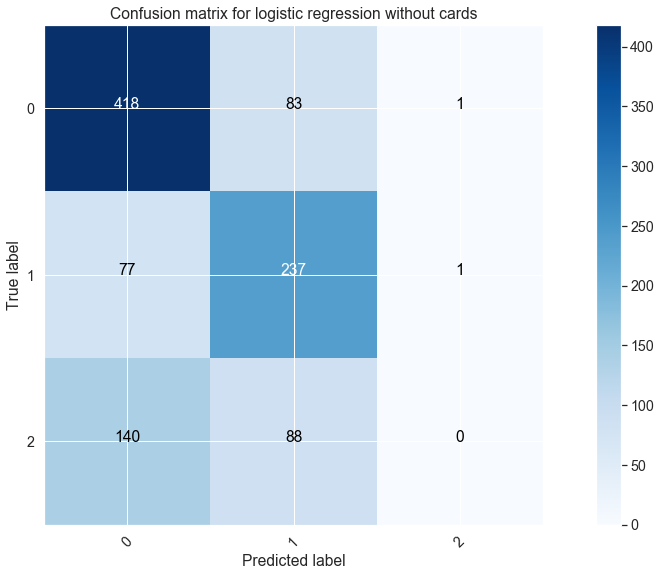

In [39]:
# confusion matrix for the 1st model
# https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python

# get an array of true and predicted values
y_true_confusion_matrix_1 = y_test1.values
y_pred_confusion_matrix_1 = y_pred1

# three classifications: home win, away win, draw
classes_confusion_matrix = [0,1,2]

confusion_matrix(y_true_confusion_matrix_1, y_pred_confusion_matrix_1, labels=[0,1,2])

cnf_matrix = confusion_matrix(y_true_confusion_matrix_1, y_pred_confusion_matrix_1, labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
sns.set(font_scale=1.3) # https://stackoverflow.com/questions/24783761/change-the-font-size-in-a-seaborn-corrplot
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2],
                      title='Confusion matrix for logistic regression without cards')

## 4.3 Linear Support Vector Machine

Excludes cards

In [40]:
# 2nd model
# linear SVM classifier for data without yellow and red cards
svm_model_linear1 = SVC(kernel = 'linear', C = 1).fit(X_train1, y_train1) 
svm_predictions1 = svm_model_linear1.predict(X_test1) 

accuracy1 = svm_model_linear1.score(X_test1, y_test1) 
print("Accuracy: {0:.2%}".format(accuracy1))


Accuracy: 62.58%


Confusion matrix, without normalization
[[421  77   4]
 [ 80 232   3]
 [143  84   1]]


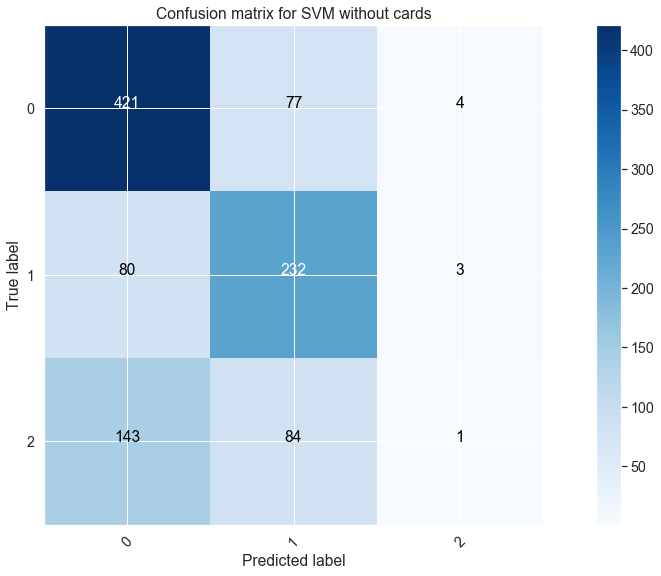

In [41]:
# confusion matrix for 2nd model
y_true_confusion_matrix_1 = y_test1.values
y_pred_confusion_matrix_1 = svm_predictions1

classes_confusion_matrix = [0,1,2]

confusion_matrix(y_true_confusion_matrix_1, y_pred_confusion_matrix_1, labels=[0,1,2])

cnf_matrix = confusion_matrix(y_true_confusion_matrix_1, y_pred_confusion_matrix_1, labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
sns.set(font_scale=1.3)
plot_confusion_matrix(cnf_matrix, classes=[0,1,2],
                      title='Confusion matrix for SVM without cards')

## 4.4 Naive Bayes

Excludes cards

In [42]:
# 3rd model 
# https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn
# naive bayes for data without yellow and red cards

#Create a Gaussian Classifier
gnb1 = GaussianNB()

#Train the model using the training sets
gnb1.fit(X_train1, y_train1)

y_pred1 = gnb1.predict(X_test1)

gnb_withoutcards_accuracy = metrics.accuracy_score(y_test1, y_pred1)
print("Accuracy: {0:.2%}".format(metrics.accuracy_score(y_test1, y_pred1)))

Accuracy: 56.65%


### 4.5 Linear SVM Classifier with Time Series Split Cross Validation

Excludes Cards

Warning: Slow computation

In [43]:
# cross validation for time series for 2nd model
cv_sets1 = TimeSeriesSplit(n_splits = 8)
cv_sets1.split(X1,y1)
model_time1 = SVC(kernel = 'linear', C = 1).fit(X_train1, y_train1)
results_time1 = model_selection.cross_val_score(model_time1, X1, y1, cv=cv_sets1)
svm_cv_withoutcards = results_time1.mean()*100.0
print("Accuracy: {0:.2%}".format(results_time1.mean()))

Accuracy: 58.14%


### 4.6 Logistic Regression with Time Series Split Cross Validation

Excludes cards

In [44]:
# cross validation for time series for 1st model
# 8 is chosen randomly from the set of recommended number of splits  
model_time1 = LogisticRegression(random_state=0, multi_class='ovr', solver='newton-cg', penalty='l2')
results_time1 = model_selection.cross_val_score(model_time1, X1, y1, cv=cv_sets1)
lr_cv_withoutcards = results_time1.mean()*100.0
print("Accuracy: {0:.2%}".format(results_time1.mean()))

/Users/ap/.pyenv/versions/pyds3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/ap/.pyenv/versions/pyds3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ap/.pyenv/versions/pyds3.7/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Accuracy: 58.00%


In [45]:
# exclude both teams and cards
y2 = result['FTR']
X2 = result
X2 = X2.drop(['FTR', 'Date', 'HomeTeam', 'AwayTeam', 'y_avg_x',	'r_avg_x', 'y_avg_y',	'r_avg_y', 'HTR'], axis=1)
X2[:] = X2[:].astype(float)

### 4.7 Logistic Regression with train-test-split

Excludes cards, team names

In [46]:
# 4th model
# LR for data without team names and cards
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y2,test_size=0.25,random_state=0,shuffle = False)
clf2 = LogisticRegression(random_state=0, multi_class='ovr', solver='newton-cg')

model2 = clf2.fit(X_train2, y_train2)
y_pred2 = model2.predict(X_test2)
out2 = model2.predict_proba(X_test2)

lr_withoutteamscards_accuracy = metrics.accuracy_score(y_test2, y_pred2)
print("Accuracy: {0:.2%}".format(metrics.accuracy_score(y_test2, y_pred2)))

Accuracy: 62.87%


Confusion matrix, without normalization
[[420  82   0]
 [ 78 237   0]
 [138  90   0]]


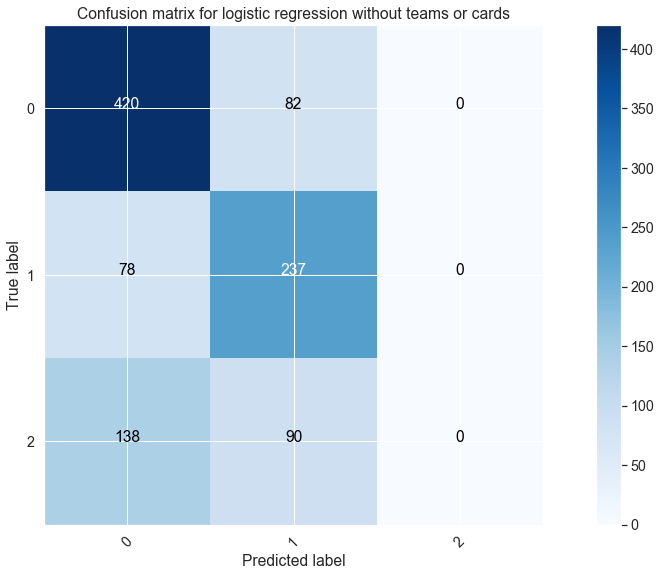

In [47]:
# confusion matrix for 4th model
y_true_confusion_matrix_4 = y_test2.values
y_pred_confusion_matrix_4 = y_pred2

classes_confusion_matrix = [0,1,2]

confusion_matrix(y_true_confusion_matrix_4, y_pred_confusion_matrix_4, labels=[0,1,2])

cnf_matrix = confusion_matrix(y_true_confusion_matrix_4, y_pred_confusion_matrix_4, labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
sns.set(font_scale=1.3)
plot_confusion_matrix(cnf_matrix, classes=[0,1,2],
                      title='Confusion matrix for logistic regression without teams or cards')

###4.8 Naive Bayes
Excludes cards and teams

In [48]:
# 6th model
# naive bayes for data without team names and cards
#Create a Gaussian Classifier
gnb2 = GaussianNB()

#Train the model using the training sets
gnb2.fit(X_train2, y_train2)

#Predict the response for test dataset
y_pred2 = gnb2.predict(X_test2)

# Model Accuracy, how often is the classifier correct?
gnb_withoutteamscards_accuracy = metrics.accuracy_score(y_test2, y_pred2)
print("Accuracy: {0:.2%}".format(metrics.accuracy_score(y_test2, y_pred2)))

Accuracy: 56.75%


## 4.9 Linear SVM Classifier

Excludes cards, team names

In [49]:
# 5th model
# linear SVM classifier for data without team names and cards
svm_model_linear2 = SVC(kernel = 'linear', C = 1).fit(X_train2, y_train2) 
svm_predictions2 = svm_model_linear2.predict(X_test2) 
  
# model accuracy for X_test   
accuracy2 = svm_model_linear2.score(X_test2, y_test2) 
print("Accuracy: {0:.2%}".format(accuracy2))

Accuracy: 62.78%


Confusion matrix, without normalization
[[427  75   0]
 [ 85 229   1]
 [144  84   0]]


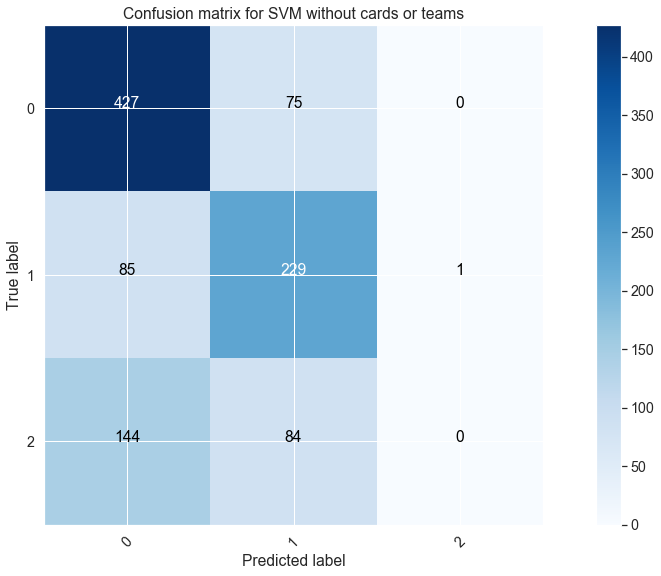

In [50]:
# confusion matrix for the 5th model
y_true_confusion_matrix_5 = y_test2.values
y_pred_confusion_matrix_5 = svm_predictions2

classes_confusion_matrix = [0,1,2]

confusion_matrix(y_true_confusion_matrix_5, y_pred_confusion_matrix_5, labels=[0,1,2])

cnf_matrix = confusion_matrix(y_true_confusion_matrix_5, y_pred_confusion_matrix_5, labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
sns.set(font_scale=1.3)
plot_confusion_matrix(cnf_matrix, classes=[0,1,2],
                      title='Confusion matrix for SVM without cards or teams')

## 4.10 Linear SVM Classifier

Excludes cards, team names

Team Series Split Cross Validation

In [51]:
# cross validation for time series for the 5th model
cv_sets22 = TimeSeriesSplit(n_splits = 8)
cv_sets22.split(X2,y2)
model_time22 = SVC(kernel = 'linear', C = 1).fit(X_train2, y_train2)
results_time22 = model_selection.cross_val_score(model_time22, X2, y2, cv=cv_sets22)
svm_cv_withoutteamscards = results_time22.mean()*100.0
print("Accuracy: {0:.2%}".format(results_time22.mean())) # 58.54%

Accuracy: 58.35%


## 4.11 Logistic Regression

Excludes cards, team names

Time Series Split Cross Validation

In [52]:
# cross validation for time series 4th model
# 8 is chosen randomly from the set of recommended number of splits 
model_time2 = LogisticRegression(random_state=0, multi_class='ovr', solver='newton-cg', penalty='l2')
results_time2 = model_selection.cross_val_score(model_time2, X2, y2, cv=cv_sets22)
lr_cv_withoutteamscards = results_time2.mean()*100.0
print("Accuracy: {0:.2%}".format(results_time2.mean()))

/Users/ap/.pyenv/versions/pyds3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ap/.pyenv/versions/pyds3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ap/.pyenv/versions/pyds3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ap/.pyenv/versions/pyds3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ap/.pyenv/versions/pyds3.7/lib/python3.7/site-packages/scipy/optimize/lin

Accuracy: 57.95%


# Results

Here, we present our results

In [53]:
# accuracy values for the different models

accuracy2 = {'logistic regression without cards': lr_withoutcards_accuracy,
            'linear SVM without cards': accuracy1,
            'GNB without cards': gnb_withoutcards_accuracy,
            'logistic regression without teams or cards': lr_withoutteamscards_accuracy,
            'linear SVM without teams or cards': accuracy2,
            'GNB without teams or cards': gnb_withoutteamscards_accuracy}
accuracy2 = pd.DataFrame(data=accuracy2, index=[0])
accuracy2

,logistic regression without cards,linear SVM without cards,GNB without cards,logistic regression without teams or cards,linear SVM without teams or cards,GNB without teams or cards
0,0.626794,0.625837,0.566507,0.628708,0.627751,0.567464


In [54]:
# cross validation for the different models

crossvalidation = {'logistic regression without cards': lr_cv_withoutcards,
                   'linear SVM without cards': svm_cv_withoutcards,
                   'logistic regression without teams or cards': lr_cv_withoutteamscards,
                   'linear SVM without teams or cards': svm_cv_withoutteamscards}
crossvalidation = pd.DataFrame(data=crossvalidation, index=[0])
crossvalidation 

,logistic regression without cards,linear SVM without cards,logistic regression without teams or cards,linear SVM without teams or cards
0,58.001078,58.135776,57.947198,58.351293


In [55]:
# start forming data sheet for test set
testc = epl_test.copy()

In [56]:
# first encode teams (+ important, a new team is added and coded with 36)
testc = testc.drop('Date', axis=1)
testc = testc.replace({'Arsenal' : 0, 'Aston Villa' : 1, 'Birmingham' : 2, 'Blackburn' : 3, 'Blackpool' : 4,
       'Bolton' : 5, 'Bournemouth' : 6, 'Brighton' : 7, 'Burnley' : 8, 'Cardiff' : 9,
       'Chelsea' : 10, 'Crystal Palace' : 11, 'Everton' : 12, 'Fulham' : 13, 'Huddersfield' : 14,
       'Hull' : 15, 'Leicester' : 16, 'Liverpool' : 17, 'Man City' : 18, 'Man United' : 19,
       'Middlesbrough' : 20, 'Newcastle' : 21, 'Norwich' : 22, 'Portsmouth' : 23, 'QPR' : 24,
       'Reading' : 25, 'Southampton' : 26, 'Stoke' : 27, 'Sunderland' : 28, 'Swansea' : 29,
       'Tottenham' : 30, 'Watford' : 31, 'West Brom' : 32, 'West Ham' : 33, 'Wigan' : 34, 'Wolves' : 35, 'Sheffield United' : 36})

In [57]:
# based on the testc table, we know we have one new value for the team we have never seen before
# assign this team index of 0 (chosen randomly) to recognise it in data formation
testc['HomeIndex'] = 0
testc['AwayIndex'] = 0
for i in range(0,10):
    if (testc.iloc[i].at['HomeTeam'] == 36):
        testc.iloc[i].at['HomeIndex'] = 0
        testc.at[i, 'AwayIndex'] = max(result.where(result['HomeTeam']==testc.iloc[i].at['AwayTeam']).last_valid_index(), result.where(result['AwayTeam']==testc.iloc[i].at['AwayTeam']).last_valid_index())
    else:
        testc.at[i, 'HomeIndex'] = max(result.where(result['HomeTeam']==testc.iloc[i].at['HomeTeam']).last_valid_index(), result.where(result['AwayTeam']==testc.iloc[i].at['HomeTeam']).last_valid_index())
        testc.at[i, 'AwayIndex'] = max(result.where(result['HomeTeam']==testc.iloc[i].at['AwayTeam']).last_valid_index(), result.where(result['AwayTeam']==testc.iloc[i].at['AwayTeam']).last_valid_index())

In [58]:
testc['HomeIndex'] = testc['HomeIndex'].astype('int32')
testc['AwayIndex'] = testc['AwayIndex'].astype('int32')
testc

,HomeTeam,AwayTeam,HomeIndex,AwayIndex
0,6,31,4172,4179
1,1,18,3030,4170
2,10,8,4174,4171
3,11,0,4172,4171
4,12,7,4178,4170
5,16,26,4174,4177
6,19,22,4176,3032
7,36,33,0,4179
8,30,17,4178,4175
9,35,21,4175,4173


In [59]:
# now we gather statistics data on the teams we need to make predictions for
# for the case of unseen team (HomeIndex = 0), we assume that to be selected in the new season, its data is 
# approximately equivalent to the average of the data of all teams playing in the past season (all games in 2018-2019)
# all the remaining teams are assigned the most recent game values
for i in range(0, 10):
    if testc.iloc[i].at['HomeIndex'] == 0:
        testc.at[i, 'g_pct_avg_x'] = (result.loc[result['Date'] > '2018-01-01', 'g_pct_avg_x'].mean() + result.loc[result['Date'] > '2018-01-01', 'g_pct_avg_y'].mean())/2
        testc.at[i, 'htg_pct_avg_x'] = (result.loc[result['Date'] > '2018-01-01', 'htg_pct_avg_x'].mean() + result.loc[result['Date'] > '2018-01-01', 'htg_pct_avg_y'].mean())/2
        testc.at[i, 's_pct_avg_x'] = (result.loc[result['Date'] > '2018-01-01', 's_pct_avg_x'].mean() + result.loc[result['Date'] > '2018-01-01', 's_pct_avg_y'].mean())/2
        testc.at[i, 'st_pct_avg_x'] = (result.loc[result['Date'] > '2018-01-01', 'st_pct_avg_x'].mean() + result.loc[result['Date'] > '2018-01-01', 'st_pct_avg_y'].mean())/2
        testc.at[i, 'g_to_s_avg_x'] = (result.loc[result['Date'] > '2018-01-01', 'g_to_s_avg_x'].mean() + result.loc[result['Date'] > '2018-01-01', 'g_to_s_avg_y'].mean())/2
        testc.at[i, 'g_to_st_avg_x'] = (result.loc[result['Date'] > '2018-01-01', 'g_to_st_avg_x'].mean() + result.loc[result['Date'] > '2018-01-01', 'g_to_st_avg_y'].mean())/2
        testc.at[i, 'y_avg_x'] = (result.loc[result['Date'] > '2018-01-01', 'y_avg_x'].mean() + result.loc[result['Date'] > '2018-01-01', 'y_avg_y'].mean())/2
        testc.at[i, 'r_avg_x'] = (result.loc[result['Date'] > '2018-01-01', 'r_avg_x'].mean() + result.loc[result['Date'] > '2018-01-01', 'r_avg_y'].mean())/2
        testc.at[i, 'elo_x'] = 1500
        if result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['HomeTeam'] == testc.iloc[i].at['AwayTeam']:
            testc.at[i, 'g_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['g_pct_avg_y']
            testc.at[i, 'htg_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['htg_pct_avg_y']
            testc.at[i, 's_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['s_pct_avg_y']
            testc.at[i, 'st_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['st_pct_avg_y']
            testc.at[i, 'g_to_s_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['g_to_s_avg_y']
            testc.at[i, 'g_to_st_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['g_to_st_avg_y']
            testc.at[i, 'y_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['y_avg_y']
            testc.at[i, 'r_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['r_avg_y']
            testc.at[i, 'elo_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['elo_y']
        else:
            testc.at[i, 'g_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['g_pct_avg_x']
            testc.at[i, 'htg_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['htg_pct_avg_x']
            testc.at[i, 's_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['s_pct_avg_x']
            testc.at[i, 'st_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['st_pct_avg_x']
            testc.at[i, 'g_to_s_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['g_to_s_avg_x']
            testc.at[i, 'g_to_st_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['g_to_st_avg_x']
            testc.at[i, 'y_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['y_avg_x']
            testc.at[i, 'r_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['r_avg_x']
            testc.at[i, 'elo_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['elo_x']
    else:
        # first home team
        if result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['HomeTeam'] == testc.iloc[i].at['HomeTeam']:
            testc.at[i, 'g_pct_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['g_pct_avg_x']
            testc.at[i, 'htg_pct_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['htg_pct_avg_x']
            testc.at[i, 's_pct_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['s_pct_avg_x']
            testc.at[i, 'st_pct_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['st_pct_avg_x']
            testc.at[i, 'g_to_s_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['g_to_s_avg_x']
            testc.at[i, 'g_to_st_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['g_to_st_avg_x']
            testc.at[i, 'y_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['y_avg_x']
            testc.at[i, 'r_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['r_avg_x']
            testc.at[i, 'elo_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['elo_x']
        else:
            testc.at[i, 'g_pct_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['g_pct_avg_y']
            testc.at[i, 'htg_pct_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['htg_pct_avg_y']
            testc.at[i, 's_pct_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['s_pct_avg_y']
            testc.at[i, 'st_pct_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['st_pct_avg_y']
            testc.at[i, 'g_to_s_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['g_to_s_avg_y']
            testc.at[i, 'g_to_st_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['g_to_st_avg_y']
            testc.at[i, 'y_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['y_avg_y']
            testc.at[i, 'r_avg_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['r_avg_y']
            testc.at[i, 'elo_x'] = result.iloc[int(testc.iloc[i].at['HomeIndex'])].at['elo_y']
        # now away team
        if result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['HomeTeam'] == testc.iloc[i].at['AwayTeam']:
            testc.at[i, 'g_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['g_pct_avg_x']
            testc.at[i, 'htg_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['htg_pct_avg_x']
            testc.at[i, 's_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['s_pct_avg_x']
            testc.at[i, 'st_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['st_pct_avg_x']
            testc.at[i, 'g_to_s_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['g_to_s_avg_x']
            testc.at[i, 'g_to_st_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['g_to_st_avg_x']
            testc.at[i, 'y_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['y_avg_x']
            testc.at[i, 'r_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['r_avg_x']
            testc.at[i, 'elo_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['elo_x']
        else:
            testc.at[i, 'g_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['g_pct_avg_y']
            testc.at[i, 'htg_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['htg_pct_avg_y']
            testc.at[i, 's_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['s_pct_avg_y']
            testc.at[i, 'st_pct_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['st_pct_avg_y']
            testc.at[i, 'g_to_s_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['g_to_s_avg_y']
            testc.at[i, 'g_to_st_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['g_to_st_avg_y']
            testc.at[i, 'y_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['y_avg_y']
            testc.at[i, 'r_avg_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['r_avg_y']
            testc.at[i, 'elo_y'] = result.iloc[int(testc.iloc[i].at['AwayIndex'])].at['elo_y']

In [60]:
# table is now complete, you may check it's equivalent to the results table
testc

,HomeTeam,AwayTeam,HomeIndex,AwayIndex,g_pct_avg_x,htg_pct_avg_x,s_pct_avg_x,st_pct_avg_x,g_to_s_avg_x,g_to_st_avg_x,y_avg_x,r_avg_x,elo_x,g_pct_avg_y,htg_pct_avg_y,s_pct_avg_y,st_pct_avg_y,g_to_s_avg_y,g_to_st_avg_y,y_avg_y,r_avg_y,elo_y
0,6,31,4172,4179,43.593750,44.237288,46.762129,47.321482,11.153137,31.900740,1.434211,0.039474,1490.778522,42.375887,41.743827,47.400109,44.654303,10.512059,33.103505,1.953947,0.105263,1504.111142
1,1,18,3030,4170,43.171831,46.085627,45.440932,43.867746,10.959405,24.540935,1.815789,0.069079,1311.896463,68.280558,71.720604,62.685500,63.783002,13.822337,31.243995,1.622010,0.069378,1956.937700
2,10,8,4174,4171,66.501084,68.709150,60.671491,61.636905,12.550067,29.876424,1.543062,0.078947,1687.553987,40.516327,39.467213,40.235927,40.013693,11.302530,29.859622,1.715789,0.036842,1508.279794
3,11,0,4172,4171,42.959373,40.804598,46.865651,46.031302,10.068642,29.791758,1.692982,0.039474,1602.774364,64.917983,61.787281,58.441674,60.041429,13.448887,29.828799,1.557416,0.086124,1666.301103
4,12,7,4178,4170,54.735622,53.534994,51.562353,53.372285,11.911652,26.750786,1.497608,0.069378,1627.937951,39.130435,35.915033,40.481412,40.613298,10.138288,27.694064,1.500000,0.078947,1408.162792
5,16,26,4174,4177,51.751637,48.908873,48.095321,49.078833,12.105023,35.620277,1.457895,0.094737,1580.638470,49.402778,49.664804,53.430232,54.257890,9.801246,28.434825,1.537594,0.067669,1483.945014
6,19,22,4176,3032,66.973314,68.965382,56.529159,58.602667,13.760722,30.244172,1.648325,0.071770,1642.822454,39.261162,37.044025,45.006072,44.133710,9.717976,22.954762,1.592105,0.059211,1392.135122
7,36,33,0,4179,49.903866,49.411919,50.063897,50.060441,11.066746,27.953287,1.581511,0.069906,1500.000000,42.375887,41.743827,47.400109,44.654303,10.512059,33.103505,1.953947,0.105263,1504.111142
8,30,17,4178,4175,60.772947,59.129693,57.767649,59.271507,11.718863,26.784780,1.545455,0.062201,1681.480450,63.616201,64.555556,61.963599,63.439077,12.472913,29.216259,1.423445,0.057416,1910.735960
9,35,21,4175,4173,40.314153,38.011696,43.996318,42.649350,10.971660,24.109756,1.730263,0.072368,1559.981204,44.469324,43.799726,48.272682,48.493870,10.747405,25.921898,1.634503,0.111111,1563.411886


In [61]:
# drop unnecessary values
testc = testc.drop(['HomeIndex', 'AwayIndex', 'HomeTeam', 'AwayTeam', 'y_avg_x', 'r_avg_x', 'y_avg_y',	'r_avg_y'], axis=1)

In [62]:
# reorder columns to match training data
testc = testc[['g_pct_avg_x',	'htg_pct_avg_x',	's_pct_avg_x',	'st_pct_avg_x',	'g_to_s_avg_x',	'g_to_st_avg_x',	'g_pct_avg_y',	'htg_pct_avg_y',	's_pct_avg_y',	'st_pct_avg_y',	'g_to_s_avg_y',	'g_to_st_avg_y',	'elo_x', 'elo_y']]

In [63]:
# svm_model_linear3 = SVC(kernel = 'linear', C = 1).fit(X_train3, y_train3) 
out = svm_model_linear2.predict(testc) 

In [64]:
out

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [65]:
finalout = epl_test.copy()
finalout['Date'] = '11 Jan 20'
finalout['FTR'] = out
finalout = finalout.replace({0 : 'H', 1 : 'A', 2 : 'D'})
# finalout = finalout.drop('Date', axis=1)
finalout

,Date,HomeTeam,AwayTeam,FTR
0,11 Jan 20,Bournemouth,Watford,H
1,11 Jan 20,Aston Villa,Man City,A
2,11 Jan 20,Chelsea,Burnley,H
3,11 Jan 20,Crystal Palace,Arsenal,H
4,11 Jan 20,Everton,Brighton,H
5,11 Jan 20,Leicester,Southampton,H
6,11 Jan 20,Man United,Norwich,H
7,11 Jan 20,Sheffield United,West Ham,H
8,11 Jan 20,Tottenham,Liverpool,A
9,11 Jan 20,Wolves,Newcastle,H


In [68]:
actualout = epl_test.copy()
actualout['Date'] = '11 Jan 20'
actualout['FTR'] = [1, 1, 0, 2, 0, 1, 0, 0, 1, 2]
actualout = actualout.replace({0 : 'H', 1 : 'A', 2 : 'D'})
actualout

,Date,HomeTeam,AwayTeam,FTR
0,11 Jan 20,Bournemouth,Watford,A
1,11 Jan 20,Aston Villa,Man City,A
2,11 Jan 20,Chelsea,Burnley,H
3,11 Jan 20,Crystal Palace,Arsenal,D
4,11 Jan 20,Everton,Brighton,H
5,11 Jan 20,Leicester,Southampton,A
6,11 Jan 20,Man United,Norwich,H
7,11 Jan 20,Sheffield United,West Ham,H
8,11 Jan 20,Tottenham,Liverpool,A
9,11 Jan 20,Wolves,Newcastle,D
